In [ ]:
import pandas as pd
import numpy as np
import quantstats as qs
import warnings
from tqdm.auto import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=UserWarning) # Quantstats might issue user warnings


# --- Function Definitions ---

# Step 1: Load Data (Mostly unchanged)
def load_data(cb_path, index_path):
    """Loads CB and index data, ensures DatetimeIndex."""
    print("--- Step 1: Loading Data ---")
    try:
        df = pd.read_parquet(cb_path)
        index_df = pd.read_parquet(index_path)
        # Ensure index_df has DatetimeIndex
        if not isinstance(index_df.index, pd.DatetimeIndex):
            index_df.index = pd.to_datetime(index_df.index)
        # Ensure df has correct MultiIndex with DatetimeIndex for trade_date
        required_levels = ['code', 'trade_date']
        if all(level in df.index.names for level in required_levels):
            date_level_idx = df.index.names.index('trade_date')
            if not isinstance(df.index.levels[date_level_idx], pd.DatetimeIndex):
                 df.index = df.index.set_levels(pd.to_datetime(df.index.levels[date_level_idx]), level='trade_date')
        else: # Try setting index if columns exist
            if all(col in df.columns for col in required_levels):
                 df['trade_date'] = pd.to_datetime(df['trade_date'])
                 df = df.set_index(required_levels)
            else: raise ValueError("CB data missing 'code' or 'trade_date' for index.")
        print(f"Loaded CB data shape: {df.shape}, Index data shape: {index_df.shape}")
        return df, index_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# Step 2: Filter Data (Mostly unchanged)
def filter_data(df, start_date, end_date, filter_rules, factors_needed):
    """Applies date range and custom filters."""
    print("--- Step 2: Filtering Data ---")
    if df is None: return None

    # Check if factor columns exist BEFORE filtering
    missing_factors = [f for f in factors_needed if f not in df.columns]
    if missing_factors:
        print(f"Error: Required factor columns missing from data: {missing_factors}")
        return None

    # Date filtering
    try:
        # Ensure 'trade_date' is in the index before trying to get level values
        if 'trade_date' not in df.index.names:
             raise KeyError("'trade_date' not found in DataFrame index levels.")
        trade_date_level = df.index.get_level_values('trade_date')
        date_mask = (trade_date_level >= start_date) & (trade_date_level <= end_date)
        df_filtered = df[date_mask].copy()
        if df_filtered.empty: raise ValueError("No data remaining after date filtering.")
        print(f"Filtered by date: {start_date} to {end_date}. Shape: {df_filtered.shape}")
    except Exception as e:
        print(f"Error during date filtering: {e}")
        return None

    # Apply filters
    df_filtered['filter_out'] = False
    # Apply essential filters not in rules (if any) - uncomment/add as needed
    # print("Applying essential filters...")
    redeem_statuses = ['已公告强赎', '公告到期赎回', '公告实施强赎', '公告提示强赎', '已满足强赎条件']
    if 'is_call' in df_filtered.columns: df_filtered.loc[df_filtered['is_call'].isin(redeem_statuses), 'filter_out'] = True
    if 'list_days' in df_filtered.columns: df_filtered.loc[df_filtered['list_days'] <= 3, 'filter_out'] = True

    print("Applying custom filters...")
    for rule in filter_rules:
        try:
            print(f" - Applying: {rule}")
            matching_indices = df_filtered.query(rule).index
            df_filtered.loc[matching_indices, 'filter_out'] = True
        except Exception as e:
            print(f"  - Warning: Could not apply filter rule '{rule}'. Error: {e}")

    # Also filter out rows where any needed factor is NaN
    print("Filtering rows with NaN in factor values...")
    nan_mask = df_filtered[factors_needed].isna().any(axis=1)
    df_filtered.loc[nan_mask, 'filter_out'] = True

    eligible_count = len(df_filtered[~df_filtered['filter_out']])
    print(f"Filtering complete. Eligible bond-days: {eligible_count}")
    if eligible_count == 0:
        print("Warning: No bonds eligible after applying all filters.")
        # Don't return None yet, let subsequent steps handle empty eligible set if needed
    return df_filtered




# --- Revised Rank-Based Scoring Function (Use this one) ---
def calculate_weighted_score(df, factor_weights):
    """
    Ranks factors based on weight direction and calculates a weighted final score based on ranks.
    Lower rank numbers are considered better. Robust index handling.
    """
    print("--- Step 3: Calculating Weighted Score (Rank-Based) ---")
    # ... (Initial checks for df, index, filter_out column - same as before) ...
    if not isinstance(df.index, pd.MultiIndex) or not all(name in df.index.names for name in ['code', 'trade_date']):
         print(f"Error: Input DataFrame index is not MultiIndex('code', 'trade_date'). Index: {df.index}")
         return None

    df_scored = df.copy()
    df_scored['final_score'] = 0.0
    df_eligible = df_scored[~df_scored['filter_out']]

    if df_eligible.empty:
        print("Warning: No eligible bonds to score.")
        df_scored['final_score'] = np.nan
        for factor in factor_weights.keys(): df_scored[f"{factor}_rank"] = np.nan
        return df_scored

    if not isinstance(df_eligible.index, pd.MultiIndex) or 'trade_date' not in df_eligible.index.names:
         print(f"Error: df_eligible index lost structure before ranking. Index: {df_eligible.index}")
         return None

    print("Calculating ranks and weighted score...")
    rank_data = {} # Store eligible ranks Series

    # --- Part 1: Calculate Ranks ---
    for factor, weight in factor_weights.items():
        if factor not in df_scored.columns:
            print(f"Warning: Factor '{factor}' not found. Skipping.")
            df_scored[f"{factor}_rank"] = np.nan
            continue
        if weight == 0:
             df_scored[f"{factor}_rank"] = np.nan
             continue

        ascending_rank = (weight < 0)
        print(f" - Ranking '{factor}': weight={weight}, ascending_rank={ascending_rank}")
        try:
            ranks = df_eligible.groupby(level='trade_date')[factor].rank(method='first', ascending=ascending_rank)
            rank_data[factor] = ranks
            df_scored[f"{factor}_rank"] = ranks
        except Exception as e:
            print(f"Error ranking factor '{factor}': {e}")
            df_scored[f"{factor}_rank"] = np.nan


    # --- Part 2: Combine Ranks into Final Score (Revised fillna) ---
    print("\nCombining ranks into final score...")

    # Calculate daily eligible counts ONCE
    try:
        if 'trade_date' not in df_eligible.index.names: raise ValueError("'trade_date' not in df_eligible index names for counts.")
        daily_eligible_counts = df_eligible.groupby(level='trade_date').size()
    except Exception as e:
        print(f"Error calculating daily counts: {e}")
        return None

    # Initialize final score Series aligned with df_eligible
    final_score_eligible = pd.Series(0.0, index=df_eligible.index)

    for factor, weight in factor_weights.items():
        if factor not in rank_data: continue # Skip if no ranks were calculated

        abs_weight = abs(weight)
        if abs_weight > 0:
             print(f" - Combining ranks for '{factor}' (weight: {abs_weight:.2f})")
             current_ranks = rank_data[factor] # Series with eligible ranks only

             # --- Simpler fillna using direct mapping ---
             # Create the map from date to count
             fill_map_dict = daily_eligible_counts.to_dict()
             # Get the date level from the ranks index
             rank_dates = current_ranks.index.get_level_values('trade_date')
             # Create the fill values Series by mapping dates to counts
             # Use a default large value if a date is somehow missing from the map
             fill_values = rank_dates.map(fill_map_dict).fillna(len(df_eligible)) # Get fill values

             # Ensure fill_values is a Series aligned with current_ranks
             fill_values_series = pd.Series(fill_values, index=current_ranks.index) # Create Series

             # Fill NaNs in current_ranks using the aligned fill_values_series
             # Now the 'value' passed to fillna is guaranteed to be a Series
             ranks_filled = current_ranks.fillna(value=fill_values_series) # Pass Series to value
             # --- End Simpler fillna ---


             # Check for remaining NaNs (optional)
             # if ranks_filled.isna().any():
             #     print(f"  -> Warning: NaNs still remain after fillna for factor {factor}. This is unexpected.")
             #     ranks_filled = ranks_filled.fillna(len(df_eligible))

             final_score_eligible += ranks_filled * abs_weight

    # Assign the calculated scores back
    df_scored['final_score'] = final_score_eligible
    df_scored.loc[df_scored['filter_out'], 'final_score'] = np.nan

    print("Score calculation complete.")
    return df_scored


# Step 4: Assign Quantile Bins
def assign_quantile_bins(df, score_column, num_bins):
    """Assigns quantile bins based on the score column for each day."""
    print(f"--- Step 4: Assigning {num_bins} Quantile Bins based on '{score_column}' ---")
    if df is None or score_column not in df.columns: return None
    # Ensure index is the expected MultiIndex
    if not isinstance(df.index, pd.MultiIndex) or not all(name in df.index.names for name in ['code', 'trade_date']):
         print(f"Error: DataFrame index is not the expected MultiIndex for binning. Index: {df.index}")
         return None

    df_binned = df.copy()
    df_binned['quantile_bin'] = pd.NA # Initialize with pandas NA

    eligible_scored_rows = ~df_binned['filter_out'] & ~df_binned[score_column].isna()
    if not eligible_scored_rows.any():
         print("Warning: No rows with valid scores found to assign bins.")
         return df_binned

    # --- Inside assign_quantile_bins function ---
    def qcut_safe(x, q, labels):
        # x is the Series of scores for a single day
        if x.nunique() < 2 or len(x) < q: # Check minimum conditions
            return pd.Series([pd.NA] * len(x), index=x.index)
        try:
            # --- CHANGE 'rank' to 'drop' ---
            return pd.qcut(x, q=q, labels=labels, duplicates='drop')
            # --- End Change ---
        except Exception as e:
            print(f"Warning: qcut failed on day ... Error: {e}. Assigning NA.") # Simplified warning
            return pd.Series([pd.NA] * len(x), index=x.index)
    # --- End modification ---

    # Group by 'trade_date' level before applying transform
    if 'trade_date' not in df_binned.index.names:
         print("Error: Cannot assign bins, 'trade_date' not in index.")
         return None

    # Apply qcut within each group only to eligible rows with scores
    bins = df_binned.loc[eligible_scored_rows].groupby(level='trade_date')[score_column].transform(
        lambda x: qcut_safe(x, q=num_bins, labels=False) # labels=False gives 0, 1, 2...
    )

    df_binned['quantile_bin'] = bins # Assign calculated bins back (will have NA where failed/ineligible)

    # Convert bin number to integer, keeping NAs
    df_binned['quantile_bin'] = df_binned['quantile_bin'].astype('Int64')

    binned_count = df_binned['quantile_bin'].notna().sum()
    total_eligible_scored = eligible_scored_rows.sum()
    print(f"Assigned bins to {binned_count} out of {total_eligible_scored} eligible scored bond-days.")
    if binned_count < total_eligible_scored:
         print(f"Warning: Failed to assign bins for {total_eligible_scored - binned_count} bond-days (likely due to insufficient unique scores/items on some days).")
    if binned_count == 0 and total_eligible_scored > 0:
         print("CRITICAL Warning: Failed to assign any bonds to bins despite having eligible scored rows.")


    return df_binned


# Step 5: Calculate Bin Performance
def calculate_bin_performance(df_binned, num_bins, sp_pct, commission_rate):
    """Calculates daily returns for each quantile bin."""
    print("--- Step 5: Calculating Performance for Each Bin ---")
    if df_binned is None or 'quantile_bin' not in df_binned.columns: return None
    # Ensure index is the expected MultiIndex
    if not isinstance(df_binned.index, pd.MultiIndex) or not all(name in df_binned.index.names for name in ['code', 'trade_date']):
         print(f"Error: DataFrame index is not the expected MultiIndex for performance calc. Index: {df_binned.index}")
         return None


    df_perf = df_binned.dropna(subset=['quantile_bin']).copy() # Only rows assigned to a bin
    if df_perf.empty:
        print("Warning: No bonds with valid bins found for performance calculation.")
        return pd.DataFrame() # Return empty DataFrame

    print("Calculating next-day returns and applying stop-profit...")
    # --- Ensure grouping by 'code' level ---
    if 'code' not in df_perf.index.names:
         raise ValueError("'code' level not found in index for grouping in performance calc.")
    grouped = df_perf.groupby(level='code')
    # --- End Grouping Check ---
    df_perf['aft_open'] = grouped['open'].shift(-1)
    df_perf['aft_close'] = grouped['close'].shift(-1)
    df_perf['aft_high'] = grouped['high'].shift(-1)
    df_perf['time_return'] = grouped['pct_chg'].shift(-1)

    sp_triggered_high = (df_perf['aft_high'] >= df_perf['close'] * (1 + sp_pct))
    sp_triggered_open = (df_perf['aft_open'] >= df_perf['close'] * (1 + sp_pct))
    df_perf.loc[sp_triggered_open, 'time_return'] = (df_perf['aft_open'] - df_perf['close']) / df_perf['close']
    df_perf.loc[sp_triggered_high & ~sp_triggered_open, 'time_return'] = sp_pct

    df_perf.dropna(subset=['time_return'], inplace=True)
    if df_perf.empty:
         print("Warning: No valid next-day returns found after stop-profit calculation.")
         return pd.DataFrame()

    print("Calculating raw daily returns per bin...")
    # --- Ensure grouping by 'trade_date', 'quantile_bin' ---
    if 'trade_date' not in df_perf.index.names:
         raise ValueError("'trade_date' level not found in index for grouping returns.")
    raw_bin_returns = df_perf.groupby(['trade_date', 'quantile_bin'])['time_return'].mean()
    # --- End Grouping Check ---
    raw_bin_returns_unstacked = raw_bin_returns.unstack(level='quantile_bin')

    print("Calculating approximate transaction costs per bin...")
    bin_costs = {}
    all_bin_signals = {}

    # --- Use df_binned (with NAs in quantile_bin) for cost calculation ---
    # It contains the full universe needed for accurate turnover signal diffs
    print("Calculating approximate transaction costs per bin...")
    bin_costs = {}
    all_bin_signals = {} # Store signals for each bin

    # --- Use df_binned (with NAs in quantile_bin) for cost calculation ---
    for i in range(num_bins):
        signal_col_name = f'signal_bin_{i}'
        # Ensure 'quantile_bin' exists before comparison
        if 'quantile_bin' not in df_binned.columns:
             print(f"Error: 'quantile_bin' column missing for cost calculation of bin {i}")
             continue

        # *** FIX: Handle pd.NA before comparison ***
        # Create the boolean condition by first filling NA with an impossible bin number (e.g., -1)
        condition = (df_binned['quantile_bin'].fillna(-1) == i)
        # *** End FIX ***

        # Now use the clean boolean 'condition' in np.where
        df_binned[signal_col_name] = np.where(condition, 1, 0)

        all_bin_signals[i] = df_binned[signal_col_name] # Store the 0/1 signal

        # --- Check index before unstack ---
        # ... (rest of the cost calculation logic remains the same) ...
        if not isinstance(df_binned.index, pd.MultiIndex) or not all(name in df_binned.index.names for name in ['code', 'trade_date']):
              print(f"Error: Invalid index for unstacking in cost calculation for bin {i}. Index: {df_binned.index}")
              bin_costs[i] = pd.Series(0.0, index=raw_bin_returns_unstacked.index if 'raw_bin_returns_unstacked' in locals() else None).fillna(0) # Assign zero cost as fallback
              continue
        try:
            pos_df = df_binned[signal_col_name].unstack(level='code', fill_value=0).astype(int)
            pos_df.index = pd.to_datetime(pos_df.index) # Ensure index is datetime

            turnover = pos_df.diff().fillna(0).abs().sum(axis=1)
            prev_positions = pos_df.shift(1).sum(axis=1)
            curr_positions = pos_df.sum(axis=1)
            total_exposure_factor = (prev_positions + curr_positions).replace(0, np.nan)

            daily_cost_pct = (turnover * commission_rate) / total_exposure_factor
            daily_cost_pct = daily_cost_pct.reindex(pos_df.index).fillna(0) # Align and fill zero
            if not daily_cost_pct.empty and len(pos_df) > 0: # Check pos_df length too
                daily_cost_pct.iloc[0] = 0.5 * commission_rate if curr_positions.iloc[0] > 0 else 0

            bin_costs[i] = daily_cost_pct

        except Exception as cost_e:
            print(f"Error calculating cost for bin {i}: {cost_e}")
            bin_costs[i] = pd.Series(0.0, index=raw_bin_returns_unstacked.index if 'raw_bin_returns_unstacked' in locals() else None).fillna(0)


    print("Calculating net returns per bin...")
    net_bin_returns = {}
    valid_bins = raw_bin_returns_unstacked.columns
    print(f"Bins with calculated raw returns: {valid_bins.tolist()}")

    for i in range(num_bins):
        if i not in valid_bins:
             print(f"Skipping bin {i} (no raw returns).")
             continue # Skip if a bin had no returns

        bin_ret = raw_bin_returns_unstacked[i].fillna(0)

        # Ensure bin_costs[i] exists and align its index
        if i in bin_costs:
             bin_cst = bin_costs[i].reindex(bin_ret.index).fillna(0)
        else:
             print(f"Warning: Costs not calculated for bin {i}. Assuming zero cost.")
             bin_cst = pd.Series(0.0, index=bin_ret.index)


        net_ret = (1 + bin_ret) * (1 - bin_cst) - 1
        net_bin_returns[f'Bin_{i}'] = net_ret

    net_returns_df = pd.DataFrame(net_bin_returns)
    print("Performance calculation complete.")
    return net_returns_df


# Step 6: Analyze Factor Correlation
def analyze_factor_correlation(df, factors):
    """Calculates and displays the correlation matrix for the selected factors."""
    print("--- Step 6: Analyzing Factor Correlation ---")
    if df is None or 'filter_out' not in df.columns: return None
    if not isinstance(df.index, pd.MultiIndex) or not all(name in df.index.names for name in ['code', 'trade_date']):
         print(f"Error: DataFrame index is not the expected MultiIndex for correlation. Index: {df.index}")
         return None


    df_eligible = df[~df['filter_out']].copy()
    if df_eligible.empty: print("Warning: No eligible bonds for correlation."); return None
    if len(df_eligible) < 2: print("Warning: Less than 2 data points for correlation."); return None

    missing_factors = [f for f in factors if f not in df_eligible.columns]
    if missing_factors: print(f"Warning: Factors missing for correlation: {missing_factors}"); return None
    present_factors = [f for f in factors if f in df_eligible.columns]
    if len(present_factors) < 2: print("Warning: Need at least 2 factors for correlation."); return None

    factor_data = df_eligible[present_factors]
    factor_data = factor_data.replace([np.inf, -np.inf], np.nan)
    factor_data.dropna(inplace=True) # Drop rows with NaNs in ANY factor column being correlated

    if len(factor_data) < 2: print("Warning: Less than 2 valid data points after NaN drop for correlation."); return None

    print("Calculating Spearman rank correlation matrix...")
    try:
        correlation_matrix = factor_data.corr(method='spearman')
        print("Factor Correlation Matrix:")
        plt.figure(figsize=(max(6, len(present_factors)), max(5, len(present_factors)-1))) # Adjust size
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Factor Spearman Rank Correlation Heatmap')
        plt.show()
        return correlation_matrix
    except Exception as corr_e:
         print(f"Error calculating or plotting correlation: {corr_e}")
         return None


# --- Main Execution Function ---
def run_factor_binning_analysis(config):
    """Orchestrates the factor analysis workflow."""

    # Step 1: Load Data
    df_cb_raw, df_index = load_data(config['cb_data_path'], config['index_data_path'])
    if df_cb_raw is None: return None

    # Step 2: Filter Data
    factors_to_analyze = list(config['factors_and_weights'].keys())
    df_filtered = filter_data(df_cb_raw, config['start_date'], config['end_date'],
                              config['filters'], factors_to_analyze)
    if df_filtered is None or len(df_filtered[~df_filtered['filter_out']]) == 0:
        print("Stopping analysis due to filtering issues or no eligible data.")
        return None

    # --- DIAGNOSTIC CHECK (as requested before) ---
    try:
        eligible_counts_daily = df_filtered[~df_filtered['filter_out']].groupby(level='trade_date').size()
        print("\n--- Post-Filter Daily Eligible Bond Counts ---")
        if not eligible_counts_daily.empty:
            print(f"Min eligible bonds on any day: {eligible_counts_daily.min()}")
            print(f"Max eligible bonds on any day: {eligible_counts_daily.max()}")
            num_bins_config = config.get('num_bins', 5)
            days_below_bins = (eligible_counts_daily < num_bins_config).sum()
            total_days = len(eligible_counts_daily)
            print(f"Number of days with < {num_bins_config} eligible bonds: {days_below_bins} out of {total_days} days ({days_below_bins/total_days:.1%})")
        else:
            print("No eligible bonds found on any day according to counts.")
    except Exception as diag_e: print(f"Error during diagnostic check: {diag_e}")
    # --- END DIAGNOSTIC CHECK ---


    # Step 3: Calculate Score
    df_scored = calculate_weighted_score(df_filtered, config['factors_and_weights'])
    if df_scored is None: print("Stopping: Score calculation failed."); return None

    # --- Add this AFTER Step 3 in run_factor_binning_analysis ---
    if 'df_scored' in locals() and df_scored is not None and 'final_score' in df_scored.columns:
        print("\n--- Analyzing Final Score Distribution ---")
        eligible_scores = df_scored[~df_scored['filter_out']]['final_score'].dropna()

        if not eligible_scores.empty:
            # Pick a sample date (e.g., the first one with eligible scores)
            sample_date = eligible_scores.index.get_level_values('trade_date').min()
            scores_on_sample_date = eligible_scores.loc[(slice(None), sample_date)]

            print(f"Analyzing scores for sample date: {sample_date}")
            print(f"Number of eligible scores on this date: {len(scores_on_sample_date)}")
            print(f"Number of UNIQUE scores on this date: {scores_on_sample_date.nunique()}")
            print(f"Score value counts (top 10):\n{scores_on_sample_date.value_counts().head(10)}")

            # Plot histogram
            try:
                import matplotlib.pyplot as plt
                plt.figure(figsize=(10, 4))
                scores_on_sample_date.hist(bins=50) # Use more bins to see detail
                plt.title(f'Histogram of Final Scores on {sample_date}')
                plt.xlabel('Final Score')
                plt.ylabel('Frequency')
                plt.show()
            except Exception as plot_e:
                print(f"Could not plot histogram: {plot_e}")

        else:
            print("No valid final scores found to analyze distribution.")
    else:
        print("df_scored or final_score column not available for distribution analysis.")
    # --- End of score distribution analysis block ---

    # Step 4: Assign Bins
    df_binned = assign_quantile_bins(df_scored, 'final_score', config['num_bins'])
    if df_binned is None or df_binned['quantile_bin'].isna().all():
         print("Stopping analysis - failed to assign bins.")
         return None

    # Step 5: Calculate Bin Performance
    bin_returns_df = calculate_bin_performance(df_binned, config['num_bins'],
                                             config['stop_profit_pct'], config['commission_rate'])
    if not isinstance(bin_returns_df, pd.DataFrame) or bin_returns_df.empty:
        print("Stopping analysis - failed to calculate bin performance.")
        return None

    # Step 6: Analyze Factor Correlation
    correlation_matrix = analyze_factor_correlation(df_filtered, factors_to_analyze) # Use df_filtered

    # --- Step 7: Report Results ---
    print("\n--- Factor Analysis Results ---")
    # benchmark_returns = None
    # if df_index is not None and config['benchmark_col'] in df_index.columns:
    #     benchmark_daily = df_index[config['benchmark_col']].pct_change().fillna(0)
    #     benchmark_returns = benchmark_daily.reindex(bin_returns_df.index).fillna(0)
    #     benchmark_returns.name = config['benchmark_col']
    #     print(f"Using benchmark: {config['benchmark_col']}")
    # else: print("Benchmark not available or not found.")

    all_metrics = {}
    print("\nPerformance Metrics per Bin:")
    if not bin_returns_df.empty:
        for bin_col in bin_returns_df.columns:
            print(f"\n--- Metrics for {bin_col} ---")
            try:
                # Ensure column exists before accessing
                if bin_col in bin_returns_df:
                     metrics_df = qs.reports.metrics(bin_returns_df[bin_col], benchmark=df_index[CONFIG['benchmark_col']], display=True)
                     all_metrics[bin_col] = metrics_df
                else:
                     print(f"Column {bin_col} not found in bin returns.")
            except Exception as metrics_e:
                 print(f"Error calculating metrics for {bin_col}: {metrics_e}")

        print("\nPlotting Cumulative Returns per Bin...")
        try:
            qs.plots.cumulative_returns(bin_returns_df, benchmark=df_index[CONFIG['benchmark_col']],
                                        title=f"Cumulative Returns by Factor Score Quantile ({config['num_bins']} Bins)")
            plt.show()
        except Exception as e: print(f"Could not generate cumulative return plot: {e}")

        top_bin_col = f'Bin_{config["num_bins"]-1}'
        bottom_bin_col = 'Bin_0'
        if top_bin_col in bin_returns_df.columns and bottom_bin_col in bin_returns_df.columns:
             top_bin = bin_returns_df[top_bin_col]
             bottom_bin = bin_returns_df[bottom_bin_col]
             spread = top_bin - bottom_bin
             print("\n--- Metrics for Top Bin - Bottom Bin Spread ---")
             try:
                 qs.reports.metrics(spread, mode='full', display=True)
                 print("\nPlotting Top-Bottom Spread Cumulative Return...")
                 qs.plots.cumulative_returns(spread, benchmark=None, title="Top Bin - Bottom Bin Spread")
                 plt.show()
             except Exception as spread_e:
                  print(f"Error analyzing spread: {spread_e}")
        else:
             print("\nCould not calculate spread (Top or Bottom bin missing).")
    else:
         print("Bin returns DataFrame is empty, skipping metrics and plots.")


    print("\n--- Factor Correlation Matrix ---")
    if correlation_matrix is not None: display(correlation_matrix)
    else: print("Correlation matrix could not be calculated.")

    print("\n--- Analysis Complete ---")
    return {
        "bin_returns": bin_returns_df,
        "bin_metrics": all_metrics,
        "factor_correlation": correlation_matrix
    }



In [4]:
import pandas as pd
import numpy as np
import quantstats as qs
import warnings
from tqdm.auto import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr # Needed for IC calculation

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=UserWarning) # Quantstats might issue user warnings


# --- Function Definitions ---

# Step 1: Load Data (Unchanged)
def load_data(cb_path, index_path):
    """Loads CB and index data, ensures DatetimeIndex."""
    print("--- Step 1: Loading Data ---")
    try:
        df = pd.read_parquet(cb_path)
        index_df = pd.read_parquet(index_path)
        # Ensure index_df has DatetimeIndex
        if not isinstance(index_df.index, pd.DatetimeIndex):
            index_df.index = pd.to_datetime(index_df.index)
        # Ensure df has correct MultiIndex with DatetimeIndex for trade_date
        required_levels = ['code', 'trade_date']
        if all(level in df.index.names for level in required_levels):
            date_level_idx = df.index.names.index('trade_date')
            if not isinstance(df.index.levels[date_level_idx], pd.DatetimeIndex):
                 df.index = df.index.set_levels(pd.to_datetime(df.index.levels[date_level_idx]), level='trade_date')
        else: # Try setting index if columns exist
            if all(col in df.columns for col in required_levels):
                 df['trade_date'] = pd.to_datetime(df['trade_date'])
                 df = df.set_index(required_levels)
            else: raise ValueError("CB data missing 'code' or 'trade_date' for index.")

        # --- Add check for 'pct_chg' column ---
        if 'pct_chg' not in df.columns:
             raise ValueError("Required column 'pct_chg' not found in CB data.")
        # --- End Check ---

        print(f"Loaded CB data shape: {df.shape}, Index data shape: {index_df.shape}")
        return df, index_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# Step 2: Filter Data (Unchanged)
def filter_data(df, start_date, end_date, filter_rules, factors_needed):
    """Applies date range and custom filters."""
    print("--- Step 2: Filtering Data ---")
    if df is None: return None

    # Check if factor columns exist BEFORE filtering
    missing_factors = [f for f in factors_needed if f not in df.columns]
    if missing_factors:
        print(f"Error: Required factor columns missing from data: {missing_factors}")
        return None

    # Date filtering
    try:
        if 'trade_date' not in df.index.names:
             raise KeyError("'trade_date' not found in DataFrame index levels.")
        trade_date_level = df.index.get_level_values('trade_date')
        date_mask = (trade_date_level >= start_date) & (trade_date_level <= end_date)
        df_filtered = df[date_mask].copy()
        if df_filtered.empty: raise ValueError("No data remaining after date filtering.")
        print(f"Filtered by date: {start_date} to {end_date}. Shape: {df_filtered.shape}")
    except Exception as e:
        print(f"Error during date filtering: {e}")
        return None

    # Apply filters
    df_filtered['filter_out'] = False
    redeem_statuses = ['已公告强赎', '公告到期赎回', '公告实施强赎', '公告提示强赎', '已满足强赎条件']
    if 'is_call' in df_filtered.columns: df_filtered.loc[df_filtered['is_call'].isin(redeem_statuses), 'filter_out'] = True
    if 'list_days' in df_filtered.columns: df_filtered.loc[df_filtered['list_days'] <= 3, 'filter_out'] = True

    print("Applying custom filters...")
    for rule in filter_rules:
        try:
            print(f" - Applying: {rule}")
            matching_indices = df_filtered.query(rule).index
            df_filtered.loc[matching_indices, 'filter_out'] = True
        except Exception as e:
            print(f"  - Warning: Could not apply filter rule '{rule}'. Error: {e}")

    # Also filter out rows where any needed factor is NaN (keep this for scoring)
    # We handle NaNs specifically for IC calculation later
    # print("Filtering rows with NaN in factor values...")
    # nan_mask = df_filtered[factors_needed].isna().any(axis=1)
    # df_filtered.loc[nan_mask, 'filter_out'] = True

    eligible_count = len(df_filtered[~df_filtered['filter_out']])
    print(f"Filtering complete. Eligible bond-days: {eligible_count}")
    if eligible_count == 0:
        print("Warning: No bonds eligible after applying all filters.")
    return df_filtered

# --- NEW Step 2b: Prepare Forward Returns ---
def prepare_forward_returns(df):
    """Calculates next day's raw percentage change ('fwd_return')."""
    print("--- Step 2b: Preparing Forward Returns ---")
    if df is None: return None
    if 'pct_chg' not in df.columns:
        print("Error: 'pct_chg' column needed for forward returns is missing.")
        return None
    if not isinstance(df.index, pd.MultiIndex) or 'code' not in df.index.names:
        print("Error: DataFrame needs MultiIndex with 'code' level for forward returns.")
        return None

    df_with_fwd = df.copy()
    # Calculate next day's return for each bond
    df_with_fwd['fwd_return'] = df_with_fwd.groupby(level='code')['pct_chg'].shift(-1)

    # Optional: Fill NaN forward returns for the very last day of each bond
    # This might not be necessary if IC/Score analysis ignores NaNs anyway
    # df_with_fwd['fwd_return'] = df_with_fwd['fwd_return'].fillna(0) # Or leave as NaN

    print(f"Added 'fwd_return' column. Example NaNs (last day): {df_with_fwd['fwd_return'].isna().sum()}")
    return df_with_fwd


# --- NEW Step 2c: Calculate IC / IR ---
def calculate_ic_ir(df, factors, fwd_return_col='fwd_return'):
    """
    Calculates Information Coefficient (IC) and Information Ratio (IR) for each factor.
    IC is the Spearman rank correlation between the factor and forward returns for each day.
    """
    print(f"--- Step 2c: Calculating IC/IR for Factors vs '{fwd_return_col}' ---")
    if df is None or fwd_return_col not in df.columns:
        print(f"Error: DataFrame or '{fwd_return_col}' column missing.")
        return None
    if not isinstance(df.index, pd.MultiIndex) or 'trade_date' not in df.index.names:
        print("Error: DataFrame needs MultiIndex with 'trade_date' level for IC calc.")
        return None

    ic_results = {}
    daily_ic_series = {} # Store daily IC series for plotting

    # --- Use eligible rows only ---
    df_eligible = df[~df['filter_out']].copy()
    df_eligible = df_eligible.dropna(subset=[fwd_return_col]) # Need valid forward return

    if df_eligible.empty:
        print("Warning: No eligible data with valid forward returns for IC calculation.")
        return pd.DataFrame()

    # Group by date to calculate daily IC
    grouped = df_eligible.groupby(level='trade_date')

    for factor in tqdm(factors, desc="Calculating Factor IC"):
        if factor not in df_eligible.columns:
            print(f"Warning: Factor '{factor}' not found for IC calc. Skipping.")
            continue

        # Function to safely calculate Spearman correlation per day
        def safe_spearman(group):
            # Drop NaNs *within the group* for this specific factor and fwd_return
            group_cleaned = group[[factor, fwd_return_col]].dropna()
            if len(group_cleaned) < 2: # Need at least 2 pairs for correlation
                return np.nan
            # Use scipy.stats.spearmanr for just the correlation coefficient
            corr, p_val = spearmanr(group_cleaned[factor], group_cleaned[fwd_return_col])
            return corr

        # Apply the function to each day's group
        try:
            daily_ic = grouped.apply(safe_spearman)
            daily_ic_series[factor] = daily_ic.dropna() # Store non-NaN ICs

            if daily_ic.notna().sum() < 2: # Need at least 2 valid daily ICs for IR
                print(f"Warning: Factor '{factor}' has < 2 days with valid IC. Cannot calculate IR.")
                mean_ic = daily_ic.mean() if daily_ic.notna().any() else np.nan
                std_ic = np.nan
                ir = np.nan
                ic_positive_ratio = (daily_ic > 0).mean() if daily_ic.notna().any() else np.nan

            else:
                mean_ic = daily_ic.mean()
                std_ic = daily_ic.std()
                ir = mean_ic / std_ic if std_ic != 0 else np.nan # Avoid division by zero
                ic_positive_ratio = (daily_ic > 0).mean()

            ic_results[factor] = {
                'Mean IC': mean_ic,
                'IC Std Dev': std_ic,
                'IR (IC Mean/Std)': ir,
                'IC > 0 Ratio': ic_positive_ratio,
                'Num Observations (Days)': daily_ic.notna().sum()
            }
            print(f" - IC/IR for '{factor}': Mean IC={mean_ic:.4f}, IR={ir:.4f}")

        except Exception as e:
            print(f"Error calculating IC for factor '{factor}': {e}")
            ic_results[factor] = {k: np.nan for k in ['Mean IC', 'IC Std Dev', 'IR (IC Mean/Std)', 'IC > 0 Ratio', 'Num Observations (Days)']}


    # --- Plot Cumulative IC ---
    if daily_ic_series:
        plt.figure(figsize=(12, 6))
        for factor, ic_s in daily_ic_series.items():
            cumulative_ic = ic_s.cumsum()
            plt.plot(cumulative_ic.index, cumulative_ic, label=f'{factor} Cumulative IC')
        plt.title('Cumulative Factor IC Over Time')
        plt.xlabel('Date')
        plt.ylabel('Cumulative IC')
        plt.legend()
        plt.grid(True)
        plt.show()

    print("IC/IR calculation complete.")
    return pd.DataFrame(ic_results).T


# Step 3: Calculate Weighted Score (Unchanged - Rank-Based)
def calculate_weighted_score(df, factor_weights):
    """
    Ranks factors based on weight direction and calculates a weighted final score based on ranks.
    Lower rank numbers are considered better. Robust index handling.
    """
    print("--- Step 3: Calculating Weighted Score (Rank-Based) ---")
    if df is None or 'filter_out' not in df.columns:
        print("Error: Input DataFrame invalid or 'filter_out' column missing.")
        return None
    if not isinstance(df.index, pd.MultiIndex) or not all(name in df.index.names for name in ['code', 'trade_date']):
         print(f"Error: Input DataFrame index is not MultiIndex('code', 'trade_date'). Index: {df.index}")
         return None

    df_scored = df.copy()
    df_scored['final_score'] = np.nan # Initialize with NaN
    df_eligible = df_scored[~df_scored['filter_out']].copy() # Use a copy to avoid SettingWithCopyWarning

    if df_eligible.empty:
        print("Warning: No eligible bonds to score.")
        for factor in factor_weights.keys(): df_scored[f"{factor}_rank"] = np.nan
        return df_scored

    if not isinstance(df_eligible.index, pd.MultiIndex) or 'trade_date' not in df_eligible.index.names:
         print(f"Error: df_eligible index lost structure before ranking. Index: {df_eligible.index}")
         return None

    print("Calculating ranks and weighted score...")
    rank_data = {} # Store eligible ranks Series
    final_score_eligible = pd.Series(0.0, index=df_eligible.index) # Initialize score Series

    # --- Part 1: Calculate Ranks and Add to Score ---
    for factor, weight in factor_weights.items():
        if factor not in df_eligible.columns:
            print(f"Warning: Factor '{factor}' not found. Skipping.")
            df_scored[f"{factor}_rank"] = np.nan
            continue
        if weight == 0:
            df_scored[f"{factor}_rank"] = np.nan
            continue

        ascending_rank = (weight < 0) # Higher positive weight -> lower rank is better -> ascending=False
                                     # Higher negative weight -> higher rank is better -> ascending=True

        print(f" - Ranking '{factor}': weight={weight}, ascending_rank={ascending_rank}")
        try:
            # Rank only eligible rows for each day, handle NaNs within rank
            ranks = df_eligible.groupby(level='trade_date')[factor].rank(method='first', ascending=ascending_rank, na_option='keep') # Keep NaNs as NaNs in ranks

            # Store ranks back onto the main df (aligned by index)
            df_scored[f"{factor}_rank"] = ranks

            # --- Normalize ranks (optional but good practice) ---
            # Normalize rank to be between 0 and 1 (approximately, depends on NaNs)
            # Higher normalized rank means "better" according to this factor's weight direction
            group_sizes = df_eligible.groupby(level='trade_date')[factor].transform('count') # Count non-NaNs per group
            # Ensure group_sizes is aligned with ranks before division
            aligned_group_sizes = group_sizes.reindex(ranks.index)
            # Handle potential division by zero if a group has zero non-NaNs (though rank should be NaN then)
            normalized_ranks = (ranks - 1) / (aligned_group_sizes - 1)
            normalized_ranks = normalized_ranks.fillna(0.5) # Fill NaN ranks with mid-point (or choose another strategy)


            # Add weighted *normalized rank* to the final score
            # We multiply by abs(weight) because the rank direction already incorporates the sign
            final_score_eligible += normalized_ranks * abs(weight)
            # --- End Rank Normalization & Scoring ---

        except Exception as e:
            print(f"Error ranking factor '{factor}': {e}")
            df_scored[f"{factor}_rank"] = np.nan


    # --- Part 2: Assign Final Score ---
    # Normalize the combined score (e.g., scale 0-1 or standardize) - Optional
    # final_score_eligible = (final_score_eligible - final_score_eligible.min()) / (final_score_eligible.max() - final_score_eligible.min())

    # Assign the calculated scores back to the main DataFrame
    df_scored['final_score'] = final_score_eligible

    print("Score calculation complete.")
    return df_scored


# Step 4: Assign Quantile Bins (Unchanged)
def assign_quantile_bins(df, score_column, num_bins):
    """Assigns quantile bins based on the score column for each day."""
    print(f"--- Step 4: Assigning {num_bins} Quantile Bins based on '{score_column}' ---")
    if df is None or score_column not in df.columns: return None
    if not isinstance(df.index, pd.MultiIndex) or not all(name in df.index.names for name in ['code', 'trade_date']):
         print(f"Error: DataFrame index is not the expected MultiIndex for binning. Index: {df.index}")
         return None

    df_binned = df.copy()
    df_binned['quantile_bin'] = pd.NA # Initialize with pandas NA

    eligible_scored_rows = ~df_binned['filter_out'] & df_binned[score_column].notna() # Use .notna() for pandas NA compatibility
    if not eligible_scored_rows.any():
         print("Warning: No rows with valid scores found to assign bins.")
         return df_binned

    def qcut_safe(x, q, labels):
        if x.nunique() < 2 or len(x) < q:
            return pd.Series([pd.NA] * len(x), index=x.index)
        try:
            return pd.qcut(x, q=q, labels=labels, duplicates='drop') # labels=False -> 0, 1, ... q-1
        except Exception as e:
            # print(f"Warning: qcut failed on day ... Error: {e}. Assigning NA.") # Reduced verbosity
            return pd.Series([pd.NA] * len(x), index=x.index)

    if 'trade_date' not in df_binned.index.names:
         print("Error: Cannot assign bins, 'trade_date' not in index.")
         return None

    # Apply qcut within each group only to eligible rows with scores
    # Higher score = better -> should be in higher bin number (e.g., Bin 4 for 5 bins)
    bins = df_binned.loc[eligible_scored_rows].groupby(level='trade_date')[score_column].transform(
        lambda x: qcut_safe(x, q=num_bins, labels=False) # labels=False gives 0, 1, 2...
    )

    df_binned['quantile_bin'] = bins # Assign calculated bins back (will have NA where failed/ineligible)

    # Convert bin number to integer, keeping NAs
    df_binned['quantile_bin'] = df_binned['quantile_bin'].astype('Int64')

    binned_count = df_binned['quantile_bin'].notna().sum()
    total_eligible_scored = eligible_scored_rows.sum()
    print(f"Assigned bins to {binned_count} out of {total_eligible_scored} eligible scored bond-days.")
    if binned_count < total_eligible_scored:
         print(f"Warning: Failed to assign bins for {total_eligible_scored - binned_count} bond-days (likely due to insufficient unique scores/items on some days).")
    if binned_count == 0 and total_eligible_scored > 0:
         print("CRITICAL Warning: Failed to assign any bonds to bins despite having eligible scored rows.")

    return df_binned


# --- NEW Step 4b: Analyze Score/Return Correlation (using bins) ---
def analyze_score_return_correlation(df_binned, fwd_return_col='fwd_return', num_bins=5):
    """
    Calculates and plots the performance of portfolios formed based on score quantiles.
    Uses the RAW forward return ('fwd_return') without costs/slippage/stop-profit.
    """
    print(f"--- Step 4b: Analyzing Score vs Forward Return ('{fwd_return_col}') Correlation ---")
    if df_binned is None or 'quantile_bin' not in df_binned.columns:
        print("Error: Binned DataFrame or 'quantile_bin' column missing.")
        return None
    if fwd_return_col not in df_binned.columns:
         print(f"Error: Forward return column '{fwd_return_col}' not found in DataFrame.")
         return None
    if not isinstance(df_binned.index, pd.MultiIndex) or 'trade_date' not in df_binned.index.names:
        print("Error: DataFrame needs MultiIndex with 'trade_date' level for analysis.")
        return None

    # Select only rows that were successfully binned and have a valid forward return
    df_analysis = df_binned.dropna(subset=['quantile_bin', fwd_return_col]).copy()

    if df_analysis.empty:
        print("Warning: No data available with both valid bins and forward returns.")
        return pd.DataFrame()

    print(f"Calculating average '{fwd_return_col}' per bin per day...")
    # Group by date and the assigned bin, calculate mean forward return
    try:
        daily_bin_returns = df_analysis.groupby(['trade_date', 'quantile_bin'])[fwd_return_col].mean()
        # Unstack to get bins as columns, dates as index
        score_bin_returns_df = daily_bin_returns.unstack(level='quantile_bin')
        # Rename columns for clarity (e.g., Bin_0, Bin_1, ...)
        score_bin_returns_df.columns = [f'ScoreBin_{int(c)}' for c in score_bin_returns_df.columns]
    except Exception as e:
        print(f"Error calculating daily bin returns for score correlation: {e}")
        return pd.DataFrame()


    if score_bin_returns_df.empty:
        print("Warning: Resulting score-bin return DataFrame is empty.")
        return score_bin_returns_df

    print("Plotting cumulative returns based on score quantiles...")
    try:
        # Plot cumulative returns using quantstats
        qs.plots.cumulative_returns(score_bin_returns_df.fillna(0), # Fill NaNs for plotting
                                    title=f"Cumulative Forward Returns by Factor Score Quantile ({num_bins} Bins)")
        plt.show()
    except Exception as plot_e:
        print(f"Could not plot score-bin cumulative returns: {plot_e}")

    # --- Display Summary Statistics ---
    print("\nSummary Statistics (Average Daily Forward Return per Score Bin):")
    bin_means = score_bin_returns_df.mean() * 100 # Percentage
    bin_means.index.name = "Score Bin"
    display(bin_means.to_frame(name="Avg Daily Fwd Return (%)"))

    print("Score vs Forward Return analysis complete.")
    return score_bin_returns_df


# Step 5: Calculate Bin Performance (Strategy Backtest - Unchanged)
# This function calculates the performance of a strategy that *trades* based on the bins,
# including costs and optional stop-profit. It uses its internal calculation of
# 'time_return' which might differ from the raw 'fwd_return' used above.
def calculate_bin_performance(df_binned, num_bins, sp_pct, commission_rate):
    """Calculates daily returns for each quantile bin (strategy backtest)."""
    print("--- Step 5: Calculating Strategy Performance for Each Bin (incl. Costs/SP) ---")
    if df_binned is None or 'quantile_bin' not in df_binned.columns: return None
    if not isinstance(df_binned.index, pd.MultiIndex) or not all(name in df_binned.index.names for name in ['code', 'trade_date']):
         print(f"Error: DataFrame index is not the expected MultiIndex for performance calc. Index: {df_binned.index}")
         return None


    df_perf = df_binned.dropna(subset=['quantile_bin']).copy() # Only rows assigned to a bin
    if df_perf.empty:
        print("Warning: No bonds with valid bins found for strategy performance calculation.")
        return pd.DataFrame() # Return empty DataFrame

    print("Calculating next-day returns for strategy (with stop-profit)...")
    if 'code' not in df_perf.index.names:
         raise ValueError("'code' level not found in index for grouping in performance calc.")
    grouped = df_perf.groupby(level='code')

    # --- Get next day's OHLC and raw % change (same as fwd_return calculation) ---
    df_perf['next_open'] = grouped['open'].shift(-1)
    df_perf['next_close'] = grouped['close'].shift(-1)
    df_perf['next_high'] = grouped['high'].shift(-1)
    df_perf['raw_next_day_return'] = grouped['pct_chg'].shift(-1) # This is the raw forward return

    # --- Apply Stop-Profit Logic ---
    # Initialize strategy return with the raw next day return
    df_perf['strategy_return'] = df_perf['raw_next_day_return']

    # Check if stop-profit was triggered based on next day's high/open vs *current* close
    sp_threshold_price = df_perf['close'] * (1 + sp_pct)
    sp_triggered_high = (df_perf['next_high'] >= sp_threshold_price)
    sp_triggered_open = (df_perf['next_open'] >= sp_threshold_price)

    # If triggered at open, return is based on open price
    df_perf.loc[sp_triggered_open, 'strategy_return'] = (df_perf['next_open'] - df_perf['close']) / df_perf['close']
    # If triggered intra-day (but not at open), return is capped at stop-profit %
    df_perf.loc[sp_triggered_high & ~sp_triggered_open, 'strategy_return'] = sp_pct

    # Drop rows where strategy return couldn't be calculated (e.g., last day for a bond)
    df_perf.dropna(subset=['strategy_return'], inplace=True)
    if df_perf.empty:
         print("Warning: No valid strategy returns found after stop-profit calculation.")
         return pd.DataFrame()

    print("Calculating raw daily returns per bin for strategy...")
    if 'trade_date' not in df_perf.index.names:
         raise ValueError("'trade_date' level not found in index for grouping returns.")
    # Group by date and bin, calculate mean STRATEGY return
    raw_bin_returns = df_perf.groupby(['trade_date', 'quantile_bin'])['strategy_return'].mean()
    raw_bin_returns_unstacked = raw_bin_returns.unstack(level='quantile_bin')

    print("Calculating approximate transaction costs per bin...")
    bin_costs = {}
    all_bin_signals = {}

    # --- Use df_binned (full dataframe) for cost calculation ---
    for i in range(num_bins):
        signal_col_name = f'signal_bin_{i}'
        if 'quantile_bin' not in df_binned.columns:
             print(f"Error: 'quantile_bin' column missing for cost calculation of bin {i}")
             continue

        # Handle pd.NA before comparison
        condition = (df_binned['quantile_bin'].fillna(-1) == i) # Fill NA with impossible bin number
        df_binned[signal_col_name] = np.where(condition, 1, 0)
        all_bin_signals[i] = df_binned[signal_col_name]

        # --- Cost calculation logic (unchanged) ---
        if not isinstance(df_binned.index, pd.MultiIndex) or not all(name in df_binned.index.names for name in ['code', 'trade_date']):
              print(f"Error: Invalid index for unstacking in cost calculation for bin {i}. Index: {df_binned.index}")
              bin_costs[i] = pd.Series(0.0, index=raw_bin_returns_unstacked.index if 'raw_bin_returns_unstacked' in locals() else None).fillna(0)
              continue
        try:
            # Unstack signals: dates as index, codes as columns, 1 if in bin, 0 otherwise
            pos_df = df_binned[signal_col_name].unstack(level='code', fill_value=0).astype(int)
            if pos_df.empty: # Handle empty pos_df
                print(f"Warning: Position DataFrame empty for bin {i} cost calc.")
                bin_costs[i] = pd.Series(0.0, index=raw_bin_returns_unstacked.index).fillna(0)
                continue
            pos_df.index = pd.to_datetime(pos_df.index)

            # Calculate turnover
            turnover = pos_df.diff().fillna(0).abs().sum(axis=1)
            # Calculate total value factor (approximation: sum of positions)
            prev_positions = pos_df.shift(1).sum(axis=1)
            curr_positions = pos_df.sum(axis=1)
            # Avoid division by zero if no positions were held yesterday and today
            total_exposure_factor = (prev_positions + curr_positions).replace(0, np.nan)

            # Calculate daily cost percentage
            daily_cost_pct = (turnover * commission_rate) / total_exposure_factor
            # Align index with returns and fill NaNs (days with no exposure change or no exposure) with 0 cost
            daily_cost_pct = daily_cost_pct.reindex(pos_df.index).fillna(0)

            # Apply initial cost if starting with positions
            if not daily_cost_pct.empty and len(pos_df) > 0:
                # Assume half cost on day 1 if positions are held
                daily_cost_pct.iloc[0] = (pos_df.iloc[0].sum() * 0.5 * commission_rate) / pos_df.iloc[0].sum() if pos_df.iloc[0].sum() > 0 else 0

            bin_costs[i] = daily_cost_pct

        except Exception as cost_e:
            print(f"Error calculating cost for bin {i}: {cost_e}")
            # Fallback to zero cost if calculation fails
            bin_costs[i] = pd.Series(0.0, index=raw_bin_returns_unstacked.index if 'raw_bin_returns_unstacked' in locals() else None).fillna(0)


    print("Calculating net strategy returns per bin...")
    net_bin_returns = {}
    # Ensure columns exist before iterating (can happen if some bins had no data)
    valid_bins = raw_bin_returns_unstacked.columns
    print(f"Bins with calculated raw strategy returns: {valid_bins.tolist()}")

    for i in range(num_bins):
        if i not in valid_bins:
             print(f"Skipping strategy perf for bin {i} (no raw returns).")
             continue

        bin_ret = raw_bin_returns_unstacked[i].fillna(0) # Get raw strategy return for the bin

        # Ensure costs are available and aligned
        if i in bin_costs:
             bin_cst = bin_costs[i].reindex(bin_ret.index).fillna(0)
        else:
             print(f"Warning: Costs not calculated for bin {i}. Assuming zero cost.")
             bin_cst = pd.Series(0.0, index=bin_ret.index)

        # Calculate net return: (1 + gross) * (1 - cost) - 1
        net_ret = (1 + bin_ret) * (1 - bin_cst) - 1
        net_bin_returns[f'StratBin_{i}'] = net_ret # Rename to distinguish from score bins

    net_returns_df = pd.DataFrame(net_bin_returns)
    print("Strategy performance calculation complete.")
    return net_returns_df


# Step 6: Analyze Factor Correlation (Unchanged)
def analyze_factor_correlation(df, factors):
    """Calculates and displays the correlation matrix for the selected factors."""
    print("--- Step 6: Analyzing Factor Correlation ---")
    if df is None or 'filter_out' not in df.columns: return None
    if not isinstance(df.index, pd.MultiIndex) or not all(name in df.index.names for name in ['code', 'trade_date']):
         print(f"Error: DataFrame index is not the expected MultiIndex for correlation. Index: {df.index}")
         return None

    df_eligible = df[~df['filter_out']].copy()
    if df_eligible.empty: print("Warning: No eligible bonds for correlation."); return None
    if len(df_eligible) < 2: print("Warning: Less than 2 data points for correlation."); return None

    missing_factors = [f for f in factors if f not in df_eligible.columns]
    if missing_factors: print(f"Warning: Factors missing for correlation: {missing_factors}");
    present_factors = [f for f in factors if f in df_eligible.columns]
    if len(present_factors) < 2: print("Warning: Need at least 2 factors for correlation."); return None

    factor_data = df_eligible[present_factors]
    factor_data = factor_data.replace([np.inf, -np.inf], np.nan)
    # Drop rows with NaNs only in the columns used for this specific calculation
    factor_data.dropna(inplace=True)

    if len(factor_data) < 2: print("Warning: Less than 2 valid data points after NaN drop for correlation."); return None

    print("Calculating Spearman rank correlation matrix...")
    try:
        correlation_matrix = factor_data.corr(method='spearman')
        print("Factor Correlation Matrix:")
        plt.figure(figsize=(max(6, len(present_factors)*0.8), max(5, len(present_factors)*0.6))) # Adjust size
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
        plt.title('Factor Spearman Rank Correlation Heatmap')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        return correlation_matrix
    except Exception as corr_e:
         print(f"Error calculating or plotting correlation: {corr_e}")
         return None


# --- Main Execution Function ---
def run_factor_binning_analysis(config):
    """Orchestrates the factor analysis workflow."""

    # Step 1: Load Data
    df_cb_raw, df_index = load_data(config['cb_data_path'], config['index_data_path'])
    if df_cb_raw is None: return None

    # Extract config parameters
    start_date = config['start_date']
    end_date = config['end_date']
    filters = config['filters']
    factors_and_weights = config['factors_and_weights']
    factors_to_analyze = list(factors_and_weights.keys())
    num_bins = config.get('num_bins', 5) # Default to 5 bins if not specified
    stop_profit_pct = config['stop_profit_pct']
    commission_rate = config['commission_rate']
    benchmark_col = config.get('benchmark_col', None) # Optional benchmark

    # Step 2a: Filter Data
    df_filtered = filter_data(df_cb_raw, start_date, end_date, filters, factors_to_analyze)
    if df_filtered is None or df_filtered[~df_filtered['filter_out']].empty:
        print("Stopping analysis due to filtering issues or no eligible data.")
        return None

    # Step 2b: Prepare Forward Returns
    df_filtered = prepare_forward_returns(df_filtered)
    if df_filtered is None or 'fwd_return' not in df_filtered.columns:
         print("Stopping analysis: Failed to calculate forward returns.")
         return None

    # Step 2c: Calculate IC/IR
    ic_results = calculate_ic_ir(df_filtered, factors_to_analyze, fwd_return_col='fwd_return')

    # --- Optional Diagnostic Check (Before Scoring) ---
    try:
        eligible_counts_daily = df_filtered[~df_filtered['filter_out']].groupby(level='trade_date').size()
        print("\n--- Post-Filter Daily Eligible Bond Counts ---")
        if not eligible_counts_daily.empty:
            print(f"Min eligible bonds on any day: {eligible_counts_daily.min()}")
            print(f"Max eligible bonds on any day: {eligible_counts_daily.max()}")
            days_below_bins = (eligible_counts_daily < num_bins).sum()
            total_days = len(eligible_counts_daily)
            print(f"Number of days with < {num_bins} eligible bonds for ranking: {days_below_bins} out of {total_days} days ({days_below_bins/total_days:.1%})")
        else: print("No eligible bonds found on any day according to counts.")
    except Exception as diag_e: print(f"Error during diagnostic check: {diag_e}")
    # --- END DIAGNOSTIC CHECK ---

    # Step 3: Calculate Score
    df_scored = calculate_weighted_score(df_filtered, factors_and_weights)
    if df_scored is None: print("Stopping: Score calculation failed."); return None

    # --- Optional Score Distribution Analysis (Unchanged) ---
    if 'final_score' in df_scored.columns:
        print("\n--- Analyzing Final Score Distribution (Sample Date) ---")
        eligible_scores = df_scored[~df_scored['filter_out']]['final_score'].dropna()
        if not eligible_scores.empty:
            try:
                sample_date = eligible_scores.index.get_level_values('trade_date').min()
                scores_on_sample_date = eligible_scores.loc[(slice(None), sample_date)]
                print(f"Analyzing scores for sample date: {sample_date}")
                print(f"  Num eligible scores: {len(scores_on_sample_date)}")
                print(f"  Num UNIQUE scores: {scores_on_sample_date.nunique()}")
                # Plot histogram
                plt.figure(figsize=(10, 4))
                scores_on_sample_date.hist(bins=50)
                plt.title(f'Histogram of Final Scores on {sample_date}')
                plt.xlabel('Final Score'); plt.ylabel('Frequency')
                plt.show()
            except Exception as plot_e: print(f"Could not plot histogram: {plot_e}")
        else: print("No valid final scores found to analyze distribution.")
    # --- End Score Distribution Analysis ---

    # Step 4a: Assign Bins based on Score
    df_binned = assign_quantile_bins(df_scored, 'final_score', num_bins)
    if df_binned is None or df_binned['quantile_bin'].isna().all():
         print("Stopping analysis - failed to assign bins based on score.")
         return None

    # Step 4b: Analyze Score vs Raw Forward Return Correlation
    score_bin_fwd_returns = analyze_score_return_correlation(df_binned, 'fwd_return', num_bins)

    # Step 5: Calculate Strategy Backtest Performance (using bins, costs, SP)
    strategy_bin_returns = calculate_bin_performance(df_binned, num_bins,
                                                     stop_profit_pct, commission_rate)
    if not isinstance(strategy_bin_returns, pd.DataFrame): # Allow empty DF here
        print("Warning: Strategy backtest calculation did not return a DataFrame.")
        strategy_bin_returns = pd.DataFrame() # Ensure it's a DF for later steps

    # Step 6: Analyze Factor Correlation
    factor_correlation_matrix = analyze_factor_correlation(df_filtered, factors_to_analyze) # Use df_filtered

    # --- Step 7: Report All Results ---
    print("\n" + "="*30 + " Factor Analysis Report " + "="*30)

    # --- IC / IR Results ---
    print("\n--- Factor IC/IR Analysis ---")
    if ic_results is not None and not ic_results.empty:
        display(ic_results.sort_values('IR (IC Mean/Std)', ascending=False))
    else:
        print("IC/IR results are not available.")

    # --- Score vs Forward Return Correlation (Plot shown earlier) ---
    print("\n--- Score vs Forward Return Correlation ---")
    if score_bin_fwd_returns is not None and not score_bin_fwd_returns.empty:
        print("Analysis summary:")
        print(" - The plot 'Cumulative Forward Returns by Factor Score Quantile' shows the performance.")
        print(" - Higher score bins should ideally show higher cumulative returns.")
        display(score_bin_fwd_returns.mean().to_frame(name="Avg Daily Fwd Return")) # Show avg returns again
    else:
        print("Score vs Forward Return correlation analysis results are not available.")

    # --- Strategy Backtest Results ---
    print("\n--- Strategy Backtest Performance (per Bin) ---")
    benchmark_returns = None
    if df_index is not None and benchmark_col and benchmark_col in df_index.columns:
        # Ensure index alignment and calculate daily % change for benchmark
        benchmark_daily = df_index[benchmark_col].pct_change().fillna(0)
        # Align benchmark to strategy returns index
        if not strategy_bin_returns.empty:
            benchmark_returns = benchmark_daily.reindex(strategy_bin_returns.index).fillna(0)
            benchmark_returns.name = benchmark_col
            print(f"Using benchmark: {benchmark_col}")
        else:
             print(f"Benchmark '{benchmark_col}' available but no strategy returns to compare against.")
    else:
        print("Benchmark not specified or not found in index data.")


    strategy_metrics = {}
    if not strategy_bin_returns.empty:
        print("\nPerformance Metrics per Strategy Bin (incl. costs/SP):")
        for bin_col in strategy_bin_returns.columns:
            print(f"\n--- Metrics for {bin_col} ---")
            try:
                metrics_df = qs.reports.metrics(strategy_bin_returns[bin_col], benchmark=benchmark_returns, display=False) # display=False first
                display(metrics_df) # Display the metrics DataFrame
                strategy_metrics[bin_col] = metrics_df # Store for potential return
            except Exception as metrics_e:
                 print(f"Error calculating metrics for {bin_col}: {metrics_e}")

        print("\nPlotting Cumulative Strategy Returns per Bin...")
        try:
            qs.plots.cumulative_returns(strategy_bin_returns, benchmark=benchmark_returns, # Pass aligned benchmark here
                                        title=f"Cumulative Strategy Returns by Factor Score Quantile ({num_bins} Bins, Net of Costs/SP)")
            plt.show()
        except Exception as e: print(f"Could not generate cumulative strategy return plot: {e}")

        # --- Strategy Spread Analysis ---
        top_bin_col = f'StratBin_{num_bins-1}'
        bottom_bin_col = 'StratBin_0'
        if top_bin_col in strategy_bin_returns.columns and bottom_bin_col in strategy_bin_returns.columns:
             top_bin = strategy_bin_returns[top_bin_col]
             bottom_bin = strategy_bin_returns[bottom_bin_col]
             spread = top_bin - bottom_bin
             spread.name = "Top-Bottom Strategy Spread"
             print(f"\n--- Metrics for {spread.name} ---")
             try:
                 qs.reports.metrics(spread, mode='full', display=True)
                 print(f"\nPlotting {spread.name} Cumulative Return...")
                 qs.plots.cumulative_returns(spread, benchmark=None, title=f"{spread.name} (Net of Costs/SP)")
                 plt.show()
             except Exception as spread_e:
                  print(f"Error analyzing strategy spread: {spread_e}")
        else:
             print(f"\nCould not calculate strategy spread ({top_bin_col} or {bottom_bin_col} missing).")
    else:
         print("Strategy Bin returns DataFrame is empty, skipping metrics and plots.")


    # --- Factor Correlation Results ---
    print("\n--- Factor Correlation Matrix ---")
    if factor_correlation_matrix is not None:
        # Plot was already shown in the function
        print("(See heatmap plot above)")
        # display(factor_correlation_matrix) # Optionally display matrix again
    else:
        print("Factor correlation matrix could not be calculated.")

    print("\n" + "="*30 + " Analysis Complete " + "="*30)

    # Return a dictionary containing key results
    return {
        "ic_results": ic_results,
        "score_bin_forward_returns": score_bin_fwd_returns,
        "strategy_bin_net_returns": strategy_bin_returns,
        "strategy_metrics": strategy_metrics,
        "factor_correlation": factor_correlation_matrix,
        # Include the final binned data for potential further inspection
        "final_binned_data": df_binned
    }

# # --- Example Configuration ---
# CONFIG = {
#     'cb_data_path': 'cb_data.parquet',  # Replace with your actual path
#     'index_data_path': 'index_data.parquet', # Replace with your actual path
#     'start_date': '2021-01-01',
#     'end_date': '2023-12-31',
#     'filters': [
#         "`转股溢价率` > 0.3", # Example filter: Premium > 30%
#         "`剩余规模` < 0.1",   # Example filter: Remaining size < 0.1 Billion
#         # Add more filter rules as strings usable by df.query()
#     ],
#     'factors_and_weights': {
#         'ytm': 1.0,             # Higher YTM is better (positive weight)
#         '转股溢价率': -1.0,       # Lower Premium is better (negative weight)
#         '剩余规模': -0.5,        # Lower Remaining Size might be better (negative weight)
#         'volume_ratio': 0.2,   # Example: Higher volume ratio might be good
#         # Add more factors and their weights
#         # Positive weight: Higher factor value is considered "better" for the score
#         # Negative weight: Lower factor value is considered "better" for the score
#     },
#     'num_bins': 5,              # Number of quantiles (5 or 10)
#     'stop_profit_pct': 0.03,    # 3% stop profit for strategy backtest
#     'commission_rate': 0.001,   # 0.1% commission per transaction (adjust as needed)
#     'benchmark_col': '中证转债', # Name of the benchmark column in index_df (Optional)
# }

# # --- Run Analysis ---
# # Create dummy data if files don't exist for testing
# if __name__ == "__main__":
#     try:
#         # Attempt to load real data first
#         pd.read_parquet(CONFIG['cb_data_path'])
#         pd.read_parquet(CONFIG['index_data_path'])
#         print("Found existing data files.")
#     except FileNotFoundError:
#         print("Data files not found. Creating dummy data for demonstration.")
#         # Create Dummy CB Data
#         dates = pd.date_range(CONFIG['start_date'], CONFIG['end_date'], freq='B')
#         codes = [f'CB{i:03d}' for i in range(20)]
#         index = pd.MultiIndex.from_product([codes, dates], names=['code', 'trade_date'])
#         dummy_data = pd.DataFrame(index=index)
#         factors = list(CONFIG['factors_and_weights'].keys())
#         for factor in factors:
#             dummy_data[factor] = np.random.randn(len(index)) * (5 if factor=='ytm' else 0.1 if factor=='转股溢价率' else 0.05) + (2 if factor=='ytm' else 0.15 if factor=='转股溢价率' else 0.5)
#         dummy_data['pct_chg'] = np.random.randn(len(index)) * 0.01
#         dummy_data['open'] = np.random.rand(len(index)) * 10 + 100
#         dummy_data['high'] = dummy_data['open'] + np.random.rand(len(index)) * 2
#         dummy_data['close'] = dummy_data['high'] - np.random.rand(len(index))
#         dummy_data['low'] = dummy_data['open'] - np.random.rand(len(index)) * 2
#         dummy_data['剩余规模'] = np.random.rand(len(index)) * 5 # Example: 0-5 Billion
#         dummy_data['转股溢价率'] = np.random.rand(len(index)) * 0.5 # Example: 0-50% premium
#         dummy_data['is_call'] = '可转股'
#         dummy_data['list_days'] = np.random.randint(5, 500, size=len(index))
#         dummy_data.to_parquet(CONFIG['cb_data_path'])

#         # Create Dummy Index Data
#         index_dates = pd.date_range(CONFIG['start_date'], CONFIG['end_date'], freq='B')
#         dummy_index = pd.DataFrame(index=index_dates)
#         dummy_index[CONFIG['benchmark_col']] = 1000 * (1 + (np.random.randn(len(index_dates)) * 0.005).cumsum())
#         dummy_index.to_parquet(CONFIG['index_data_path'])
#         print(f"Created dummy data: {CONFIG['cb_data_path']}, {CONFIG['index_data_path']}")


#     # Run the full analysis
#     analysis_results = run_factor_binning_analysis(CONFIG)

#     # You can access results like:
#     # if analysis_results:
#     #     ic_df = analysis_results["ic_results"]
#     #     strategy_returns = analysis_results["strategy_bin_net_returns"]
#     #     # etc.

--- Step 1: Loading Data ---
Loaded CB data shape: (591271, 327), Index data shape: (1765, 8)
--- Step 2: Filtering Data ---
Filtered by date: 20220801 to 20240101. Shape: (168627, 327)
Applying custom filters...
 - Applying: close < 102
 - Applying: close > 155
 - Applying: left_years < 0.5
 - Applying: amount < 500
Filtering complete. Eligible bond-days: 124715
--- Step 2b: Preparing Forward Returns ---
Added 'fwd_return' column. Example NaNs (last day): 630
--- Step 2c: Calculating IC/IR for Factors vs 'fwd_return' ---


Calculating Factor IC:  20%|██        | 1/5 [00:00<00:02,  1.94it/s]

 - IC/IR for 'ytm': Mean IC=0.0478, IR=0.2603


Calculating Factor IC:  40%|████      | 2/5 [00:00<00:01,  2.03it/s]

 - IC/IR for 'conv_prem': Mean IC=0.0090, IR=0.0587


Calculating Factor IC:  60%|██████    | 3/5 [00:01<00:00,  2.16it/s]

 - IC/IR for 'turnover_5': Mean IC=-0.0314, IR=-0.1484


Calculating Factor IC:  80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

 - IC/IR for 'bond_prem': Mean IC=-0.0582, IR=-0.2713


Calculating Factor IC: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

 - IC/IR for 'theory_bias': Mean IC=-0.0136, IR=-0.1243


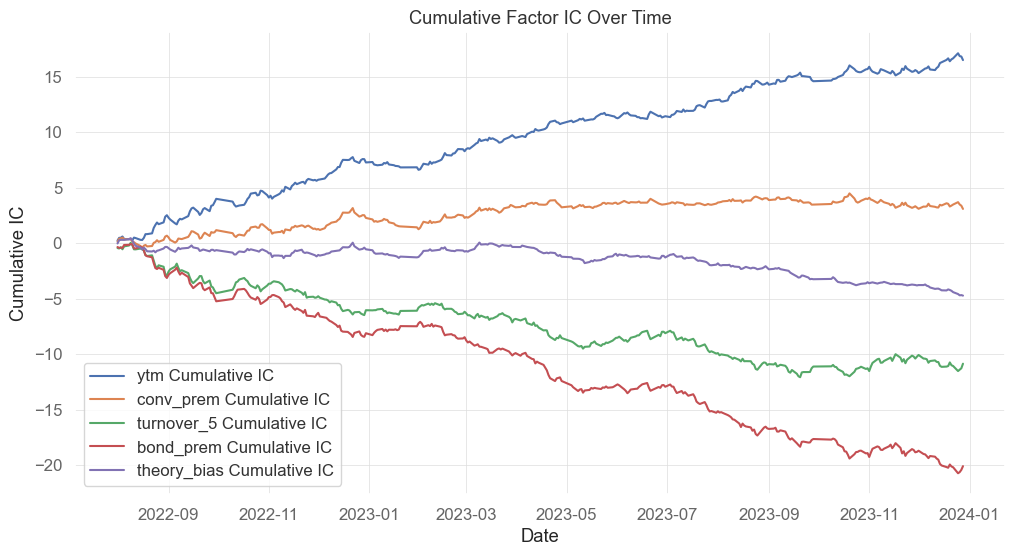

IC/IR calculation complete.

--- Post-Filter Daily Eligible Bond Counts ---
Min eligible bonds on any day: 282
Max eligible bonds on any day: 450
Number of days with < 5 eligible bonds for ranking: 0 out of 346 days (0.0%)
--- Step 3: Calculating Weighted Score (Rank-Based) ---
Calculating ranks and weighted score...
 - Ranking 'ytm': weight=1.0, ascending_rank=False
 - Ranking 'conv_prem': weight=-1.0, ascending_rank=True
 - Ranking 'turnover_5': weight=1.5, ascending_rank=False
 - Ranking 'bond_prem': weight=-1.0, ascending_rank=True
 - Ranking 'theory_bias': weight=-1, ascending_rank=True
Score calculation complete.

--- Analyzing Final Score Distribution (Sample Date) ---
Analyzing scores for sample date: 2022-08-01 00:00:00
  Num eligible scores: 299
  Num UNIQUE scores: 287


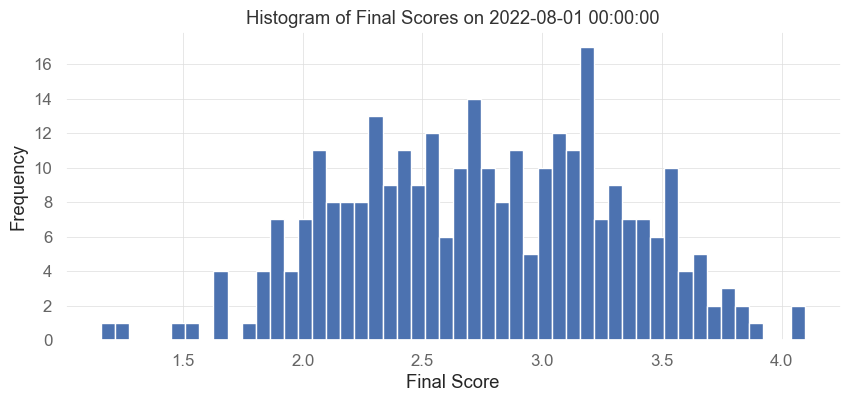

--- Step 4: Assigning 5 Quantile Bins based on 'final_score' ---
Assigned bins to 124715 out of 124715 eligible scored bond-days.
--- Step 4b: Analyzing Score vs Forward Return ('fwd_return') Correlation ---
Calculating average 'fwd_return' per bin per day...
Plotting cumulative returns based on score quantiles...
Could not plot score-bin cumulative returns: module 'quantstats.plots' has no attribute 'cumulative_returns'

Summary Statistics (Average Daily Forward Return per Score Bin):


,Avg Daily Fwd Return (%)
Score Bin,
ScoreBin_0,0.040718
ScoreBin_1,0.018216
ScoreBin_2,-0.000470
ScoreBin_3,-0.005882
ScoreBin_4,-0.063778


Score vs Forward Return analysis complete.
--- Step 5: Calculating Strategy Performance for Each Bin (incl. Costs/SP) ---
Calculating next-day returns for strategy (with stop-profit)...
Calculating raw daily returns per bin for strategy...
Calculating approximate transaction costs per bin...
Calculating net strategy returns per bin...
Bins with calculated raw strategy returns: [0, 1, 2, 3, 4]
Strategy performance calculation complete.
--- Step 6: Analyzing Factor Correlation ---
Calculating Spearman rank correlation matrix...
Factor Correlation Matrix:


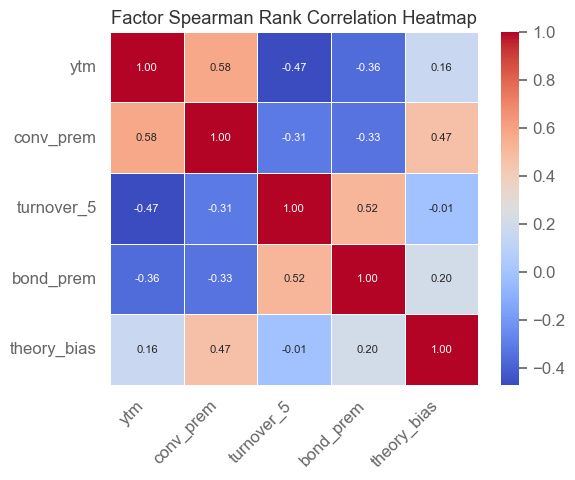


============================== Factor Analysis Report ==============================

--- Factor IC/IR Analysis ---


,Mean IC,IC Std Dev,IR (IC Mean/Std),IC > 0 Ratio,Num Observations (Days)
ytm,0.047849,0.183854,0.260256,0.602899,345.0
conv_prem,0.008990,0.153041,0.058745,0.553623,345.0
theory_bias,-0.013646,0.109794,-0.124285,0.472464,345.0
turnover_5,-0.031424,0.211777,-0.148380,0.460870,345.0
bond_prem,-0.058176,0.214461,-0.271267,0.402899,345.0



--- Score vs Forward Return Correlation ---
Analysis summary:
 - The plot 'Cumulative Forward Returns by Factor Score Quantile' shows the performance.
 - Higher score bins should ideally show higher cumulative returns.


,Avg Daily Fwd Return
Score Bin,
ScoreBin_0,0.000407
ScoreBin_1,0.000182
ScoreBin_2,-0.000005
ScoreBin_3,-0.000059
ScoreBin_4,-0.000638



--- Strategy Backtest Performance (per Bin) ---
Using benchmark: index_jsl

Performance Metrics per Strategy Bin (incl. costs/SP):

--- Metrics for StratBin_0 ---


,Benchmark,Strategy
Start Period,2022-08-01,2022-08-01
End Period,2023-12-28,2023-12-28
Risk-Free Rate,0,0
Time in Market,1.0,1.0
Cumulative Return,-15.36,0.31
CAGR﹪,2.69,0.14
Sharpe,0.74,2.04
Prob. Sharpe Ratio,0.94,0.99
Sortino,22.98,3.17
Sortino/√2,16.25,2.24



--- Metrics for StratBin_1 ---


,Benchmark,Strategy
Start Period,2022-08-01,2022-08-01
End Period,2023-12-28,2023-12-28
Risk-Free Rate,0,0
Time in Market,1.0,1.0
Cumulative Return,-15.36,0.04
CAGR﹪,2.69,0.02
Sharpe,0.74,0.32
Prob. Sharpe Ratio,0.94,0.64
Sortino,22.98,0.46
Sortino/√2,16.25,0.33



--- Metrics for StratBin_2 ---


,Benchmark,Strategy
Start Period,2022-08-01,2022-08-01
End Period,2023-12-28,2023-12-28
Risk-Free Rate,0,0
Time in Market,1.0,1.0
Cumulative Return,-15.36,-0.08
CAGR﹪,2.69,-0.04
Sharpe,0.74,-0.63
Prob. Sharpe Ratio,0.94,0.23
Sortino,22.98,-0.87
Sortino/√2,16.25,-0.62



--- Metrics for StratBin_3 ---


,Benchmark,Strategy
Start Period,2022-08-01,2022-08-01
End Period,2023-12-28,2023-12-28
Risk-Free Rate,0,0
Time in Market,1.0,1.0
Cumulative Return,-15.36,-0.08
CAGR﹪,2.69,-0.04
Sharpe,0.74,-0.68
Prob. Sharpe Ratio,0.94,0.21
Sortino,22.98,-0.92
Sortino/√2,16.25,-0.65



--- Metrics for StratBin_4 ---


,Benchmark,Strategy
Start Period,2022-08-01,2022-08-01
End Period,2023-12-28,2023-12-28
Risk-Free Rate,0,0
Time in Market,1.0,1.0
Cumulative Return,-15.36,-0.17
CAGR﹪,2.69,-0.09
Sharpe,0.74,-1.59
Prob. Sharpe Ratio,0.94,0.03
Sortino,22.98,-2.03
Sortino/√2,16.25,-1.44



Plotting Cumulative Strategy Returns per Bin...
Could not generate cumulative strategy return plot: module 'quantstats.plots' has no attribute 'cumulative_returns'

--- Metrics for Top-Bottom Strategy Spread ---
                           Strategy
-------------------------  ----------
Start Period               2022-08-01
End Period                 2023-12-28
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -36.89%
CAGR﹪                     -20.2%

Sharpe                     -7.39
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -7.08
Sortino                    -7.43
Smart Sortino              -7.12
Sortino/√2                 -5.25
Smart Sortino/√2           -5.03
Omega                      0.31

Max Drawdown               -37.32%
Longest DD Days            511
Volatility (ann.)          4.53%
Calmar                     -0.54
Skew                       -0.07
Kurtosis                   0.7

Expected Daily %           -0.13%
Expecte

In [6]:
# --- Configuration ---
CONFIG = {
    # File Paths
    'cb_data_path': '/Users/yiwei/Desktop/git/cb_data_with_factors2.pq', # CHANGE TO YOUR PATH
    'index_data_path': '/Users/yiwei/Desktop/git/index.pq', # CHANGE TO YOUR PATH

    # Analysis Settings
    'start_date': '20220801',
    'end_date': '20240101',   # Adjust end date as needed
    'num_bins': 5,           # Number of quantiles (e.g., 5 for quintiles)
    'benchmark_col': 'index_jsl',

    # Stop-Profit & Commission (for return calculation)
    'stop_profit_pct': 0.03,
    'commission_rate': 2 / 1000,

    # Data Filtering Rules (applied first)
    'filters': [
        "close < 102",
        "close > 155", # Example: wider price range for analysis
        "left_years < 0.5",
        "amount < 500",  # Example: lower liquidity threshold
        # Add other essential filters if needed (like redeem status, list_days)
        # "is_call.isin(['已公告强赎', '公告到期赎回', '公告实施强赎', '公告提示强赎', '已满足强赎条件']) == False", # Example keeping only non-redeem
        # "list_days > 3"
    ],

    # Factors to Analyze and their Weights for the Composite Score
    # Keys: Factor column names from df.
    # Values: Weight (positive means higher factor value -> better score contribution,
    #         negative means lower factor value -> better score contribution).
    # The ranking logic internally handles this direction based on weight sign.
    'factors_and_weights': {
        'ytm': 1.0,           # Higher YTM is better
        'conv_prem': -1.0,    # Lower premium is better
        'turnover_5': 1.5,    # Higher turnover might indicate interest
        'bond_prem': -1.0,    # Lower bond premium (closer to pure bond value) might be safer
        'theory_bias': -1,
        # Add other factors you want to combine
    }
}

analysis_results = run_factor_binning_analysis(CONFIG)